# Multiple Inputs in Keras
> In this chapter, you will extend your 2-input model to 3 inputs, and learn how to use Keras' summary and plot functions to understand the parameters and topology of your neural networks. By the end of the chapter, you will understand how to extend a 2-input model to 3 inputs and beyond.This is the Summary of lecture "Advanced Deep Learning with Keras", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Tensorflow-Keras, Deep_Learning]
- image: images/team_strength_model.png

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 8)

## Three-input models

### Make an input layer for home vs. away
Now you will make an improvement to the model you used in the previous chapter for regular season games. You know there is a well-documented home-team advantage in basketball, so you will add a new input to your model to capture this effect.

This model will have three inputs: team_id_1, team_id_2, and home. The team IDs will be integers that you look up in your team strength model from the previous chapter, and home will be a binary variable, 1 if team_1 is playing at home, 0 if they are not.

In [2]:
games_season = pd.read_csv('./dataset/games_season.csv')
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [3]:
games_tourney = pd.read_csv('./dataset/games_tourney.csv')
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [4]:
from tensorflow.keras.layers import Embedding, Input, Flatten
from tensorflow.keras.models import Model

# Count the unique number of teams
n_teams = np.unique(games_season['team_1']).shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

# Create an input layer for the team ID
teamid_in = Input(shape=(1, ))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

team_strength_model.summary()

Model: "Team-Strength-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
Team-Strength (Embedding)    (None, 1, 1)              10888     
_________________________________________________________________
flatten (Flatten)            (None, 1)                 0         
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


In [5]:
from tensorflow.keras.layers import Concatenate, Dense

# Create an Input for each team
team_in_1 = Input(shape=(1, ), name='Team-1-In')
team_in_2 = Input(shape=(1, ), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1, ), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, 
# then add a Dense layer

out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

### Make a model and compile it
Now that you've input and output layers for the 3-input model, wrap them up in a Keras model class, and then compile the model, so you can fit it to data and use it to make predictions on new data.



In [6]:
# Make a model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

### Fit the model and evaluate
Now that you've defined a new model, fit it to the regular season basketball data.

Use the `model` you fit in the previous exercise (which was trained on the regular season data) and evaluate the model on data for tournament games (`games_tourney`).

In [7]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1, verbose=True, validation_split=0.1, batch_size=2048)

# Evaluate the model on the games_touney dataset
print(model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']], 
                      games_tourney['score_diff'], verbose=False))

138/138 [==============================] - 0s 2ms/step - loss: 12.2876 - val_loss: 11.5519
11.686502456665039


## Summarizing and plotting models


### Model summaries
In this exercise, you will take a closer look at the summary of one of your 3-input models available in your workspace as model. Note how many layers the model has, how many parameters it has, and how many of those parameters are trainable/non-trainable.



In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Model)     (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
Home-In (InputLayer)            [(None, 1)]          0                                        

### Plotting models
In addition to summarizing your model, you can also plot your model to get a more intuitive sense of it.

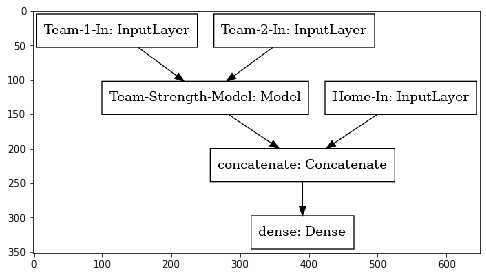

In [9]:
from tensorflow.keras.utils import plot_model

# Plot model
plot_model(model, to_file='../images/team_strength_model.png')

# Display the image
data = plt.imread('../images/team_strength_model.png')
plt.imshow(data);

## Stacking models


### Add the model predictions to the tournament data
In lesson 1 of this chapter, you used the regular season model to make predictions on the tournament dataset, and got pretty good results! Try to improve your predictions for the tournament by modeling it specifically.

You'll use the prediction from the regular season model as an input to the tournament model. This is a form of "model stacking."

To start, take the regular season model from the previous lesson, and predict on the tournament data. Add this prediction to the tournament data as a new column.

In [10]:
# Predict
games_tourney['pred'] = model.predict([games_tourney['team_1'], 
                                       games_tourney['team_2'], 
                                       games_tourney['home']])

### Create an input layer with multiple columns
In this exercise, you will look at a different way to create models with multiple inputs. This method only works for purely numeric data, but its a much simpler approach to making multi-variate neural networks.

Now you have three numeric columns in the tournament dataset: `'seed_diff'`, `'home'`, and `'pred'`. In this exercise, you will create a neural network that uses a single input layer to process all three of these numeric inputs.

This model should have a single output to predict the tournament game score difference.

In [11]:
# Create an input layer with 3 columns
input_tensor = Input(shape=(3, ))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

### Fit the model
Now that you've enriched the tournament dataset and built a model to make use of the new data, fit that model to the tournament data.

Note that this `model` has only one input layer that is capable of handling all 3 inputs, so it's inputs and outputs do not need to be a list.

Tournament games are split into a training set and a test set. The tournament games before 2010 are in the training set, and the ones after 2010 are in the test set.

In [12]:
from sklearn.model_selection import train_test_split

games_tourney_train = games_tourney[games_tourney['season'] <= 2010]
games_tourney_test = games_tourney[games_tourney['season'] > 2010]

In [13]:
# Fit the model
model.fit(games_tourney_train[['home', 'seed_diff', 'pred']],
          games_tourney_train['score_diff'],
          epochs=1,
          verbose=True);

103/103 [==============================] - 0s 715us/step - loss: 9.2063


## Evaluate the model
Now that you've fit your model to the tournament training data, evaluate it on the tournament test data. Recall that the tournament test data contains games from after 2010.



In [14]:
# Evaluate the model on the games_tourney_test dataset
print(model.evaluate(games_tourney_test[['home', 'seed_diff', 'pred']],
                     games_tourney_test['score_diff'],
                     verbose=True))

30/30 [==============================] - 0s 763us/step - loss: 9.1752
9.175172805786133
